In [711]:
using LinearAlgebra 
using Plots 
using LaTeXStrings
using CSV 
using DataFrames

plot_font = "Computer Modern"
default(fontfamily=plot_font,
        linewidth=1, framestyle=:box, label=nothing, grid=false, tickfontsize=12, labelfontsize=12, markersize=2)

## Bethe solutions

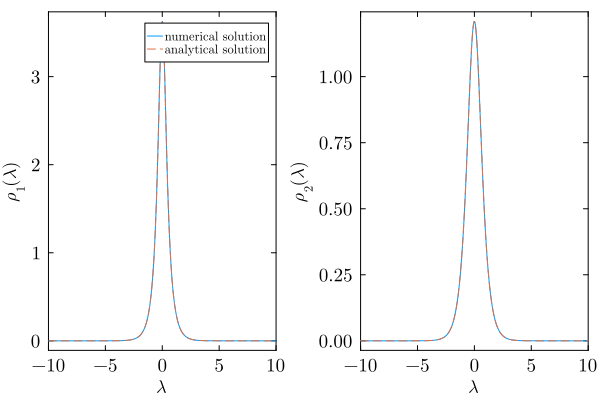

"/Users/zakariajouini/Desktop/BLBQA/Bethe/densities_D=0_h=0.pdf"

In [1026]:
K1(x,y)=inv.((x.-y).^2 .+1)/pi
K2(x,y)=-2*inv.(4*(x.-y).^2 .+1)/pi
g(x)=4*inv.(4*x.^2 .+1)

f(x,B)=B*x./(-B*x.^2 .+B .+1)
J(x,B)=B*(B*x.^2 .+B .+1)./(-B*x.^2 .+B .+1).^2

function solve_bethe(B1, B2, M)

    # Define linear problem 
    du=2/(M-1)
    u=range(-1, 1, length=M)

    A11 = Matrix{Float64}(I,M,M)
    A22 = Matrix{Float64}(I,M,M)
    A12 = zeros(M,M)
    A21 = zeros(M,M) 

    for j in 1:M 
        for l in 1:M
            w = du
            if l==1 || l==M 
                w=w/2
            end
            A11[j,l] = A11[j,l]+K1(f(u[j],B1),f(u[l],B1))*J(u[l],B1)*w  
            A22[j,l] = A22[j,l]+K1(f(u[j],B2),f(u[l],B2))*J(u[l],B2)*w 
            A12[j,l] = K2(f(u[j],B1),f(u[l],B2))*J(u[l],B2)*w 
            A21[j,l] = K2(f(u[j],B2),f(u[l],B1))*J(u[l],B1)*w 
        end
    end

    A = [A11 A12; A21 A22]

    g_=zeros(2*M)
    for j in 1:M
        g_[j] = g(f(u[j],B1))
    end

    R = inv(A)*g_
    return R, u
end

M=1000
B1 = 100
B2 = 100
R, u = solve_bethe(B1, B2, M)
R1sol(λ) = 2*pi/3*sin(pi/3)*inv.(cosh.(2*pi*λ/3).-cos(pi/3))
R2sol(λ) = 2*pi/3*sin(2*pi/3)*inv.(cosh.(2*pi*λ/3).-cos(2*pi/3))

p1=plot(f(u,B1), R[1:M], xlim=(-10, 10), xlabel=L"\lambda", ylabel=L"\rho_1(\lambda)", label="numerical solution")
plot!(-10:0.01:10, R1sol(-10:0.01:10), linestyle=:dash, label="analytical solution")
p2=plot(f(u,B2), R[M+1:end], xlim=(-10, 10), xlabel=L"\lambda", ylabel=L"\rho_2(\lambda)")
plot!(-10:0.01:10, R2sol(-10:0.01:10), linestyle=:dash)
h1=plot(p1, p2, layout=(1,2))
display(h1)

savefig("densities_D=0_h=0.pdf")


## Densities

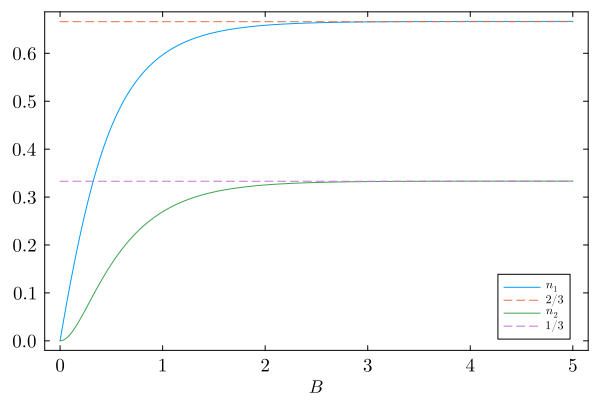

In [1097]:
function density(B1, B2)
    M = 100
    R, u = solve_bethe(B1, B2, M)
    du=(u[2]-u[1])

    n1 = 0; n2 = 0
    for j in 1:M
        w=du 
        if j==1 || j==M 
            w=w/2
        end
        n1 = n1 + J(u[j],B1)*R[j]*w
        n2 = n2 + J(u[j],B2)*R[j+M]*w
    end

    return n1, n2
end

Bs = 0:0.01:5
n1 = zeros(length(Bs))
n2 = zeros(length(Bs))
for j in eachindex(Bs) 
    n1[j], n2[j] = density(Bs[j], Bs[j])
end

plot(Bs, n1/(2*pi), xlabel=L"B", label=L"n_1")
plot!(Bs, 0.666*ones(length(Bs)), linestyle=:dash, label=L"2/3")
plot!(Bs, n2/(2*pi), label=L"n_2")
plot!(Bs, 0.333*ones(length(Bs)), linestyle=:dash, label=L"1/3")

## Dressed energies

In [971]:
e01(x) = -2*inv.(4*x.^2 .+1)/pi
K1(x,y)=inv.((x.-y).^2 .+1)/pi
K2(x,y)=-2*inv.(4*(x.-y).^2 .+1)/pi

f(x,B)=B*x./(-B*x.^2 .+B .+1)
J(x,B)=B*(B*x.^2 .+B .+1)./(-B*x.^2 .+B .+1).^2

function dressed_energy(B1, B2, M, h=0, D=0)
    # Define linear problem 
    u=LinRange(-1, 1, M)
    du=(u[2]-u[1])

    A11 = Matrix{Float64}(I,M,M)
    A22 = Matrix{Float64}(I,M,M)
    A12 = zeros(M,M)
    A21 = zeros(M,M) 

    for j in 1:M 
        for l in 1:M
            w = du
            if l==1 || l==M 
                w=w/2
            end
            A11[j,l] = A11[j,l]+K1(f(u[j],B1),f(u[l],B1))*J(u[l],B1)*w  
            A22[j,l] = A22[j,l]+K1(f(u[j],B2),f(u[l],B2))*J(u[l],B2)*w 
            A12[j,l] = K2(f(u[j],B1),f(u[l],B2))*J(u[l],B2)*w 
            A21[j,l] = K2(f(u[j],B2),f(u[l],B1))*J(u[l],B1)*w 
        end
    end

    A = [A11 A12; A21 A22]

    e0=zeros(2*M)
    field=h
    for j in 1:M
        e0[j] = e01(f(u[j],B1))+field/(2*pi)-D/(2*pi)
        e0[M+j] = field/(2*pi)+D/(2*pi)
    end

    e = inv(A)*e0
    return e, u
end

dressed_energy (generic function with 3 methods)

## Spin susceptibility

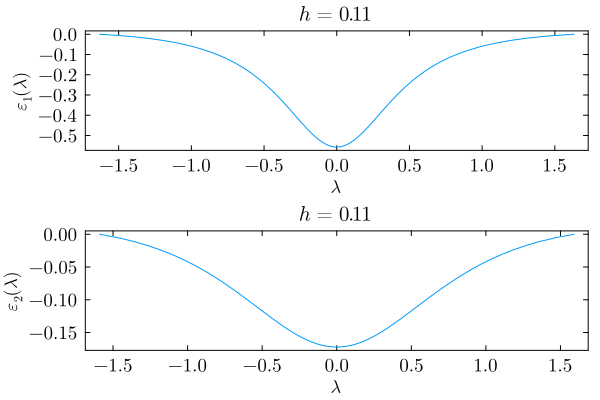

(1.6314544819940515, 1.5904254587109732)

In [1145]:
using NLsolve
function dressed_boundary(B1, B2, M, h_, D)
    e, u = dressed_energy(B1, B2, M, h_, D)
    return e[M], e[end]
end

h_=0.11
D=0
M=100
function residual!(F, x)
    B1, B2 = x
    F[1], F[2] = dressed_boundary(B1, B2, M, h_, 0)
end

# Initial guess
x0 = [1.0, 1.0]

# Solve
sol = nlsolve(residual!, x0)
B1, B2 = sol.zero

e, u=dressed_energy(B1, abs.(B2), M, h_, D)
p1=plot(f(u, B1), e[1:M], xlabel=L"\lambda", ylabel=L"\epsilon_1(\lambda)", title=L"h=%$(h_)")
p2=plot(f(u, abs.(B2)), e[M+1:end], xlabel=L"\lambda", ylabel=L"\epsilon_2(\lambda)", title=L"h=%$(h_)")
h1=plot(p1, p2, layout=(2, 1))
display(h1)

@show B1, B2

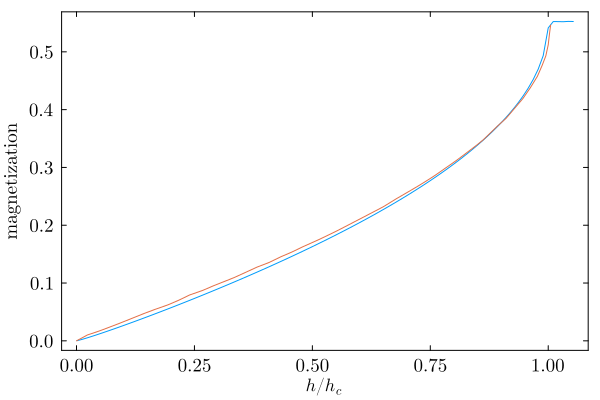

In [942]:
hs = 0.001:0.01:1
D=0
M=100
B1s=[]; B2s=[]
for h_ in hs
    function residual!(F, x)
        B1, B2 = x
        F[1], F[2] = dressed_boundary(B1, B2, M, h_, D)
    end

    x0 = [1.0, 0.5]
    sol = nlsolve(residual!, x0)
    B1_temp, B2_temp = sol.zero
    push!(B1s, B1_temp)
    push!(B2s, B2_temp)
end

df = CSV.read("../DMRG/sim/M_Bethe2.csv", DataFrame)
h_=df[:,1]
m=df[:,2]
@show m[1]
push!(m, 0)
push!(h_, 0)
h_=sort(h_)
m=sort(m)


n1 = zeros(length(B1s))
n2 = zeros(length(B2s))
for j in eachindex(B1s)
    n1[j], n2[j] = density(abs.(B1s[j]), abs.(B2s[j]))
end

plot(hs/hc, [1-n1[j]/(2*pi)-n2[j]/(2*pi) for j in 1:length(B1s)])
plot!(h_, m, xlabel=L"h/h_c", ylabel="magnetization")

## Compressibility

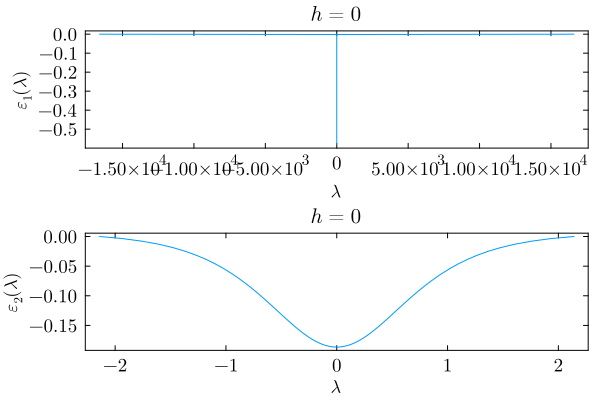

(16610.437666756894, 2.1407591027915105)

In [1146]:
using NLsolve
function dressed_boundary(B1, B2, M, h_, D)
    e, u = dressed_energy(B1, B2, M, h_, D)
    return e[M], e[end]
end

h_=0
D=0.1
M=100
function residual!(F, x)
    B1, B2 = x
    F[1], F[2] = dressed_boundary(B1, B2, M, 0, D)
end

# Initial guess
x0 = [10., .5]

# Solve
sol = nlsolve(residual!, x0)
B1, B2 = sol.zero

e, u=dressed_energy(B1, abs.(B2), M, 0, D)
p1=plot(f(u, abs.(B1)), e[1:M], xlabel=L"\lambda", ylabel=L"\epsilon_1(\lambda)", title=L"h=%$(h_)")
p2=plot(f(u, abs.(B2)), e[M+1:end], xlabel=L"\lambda", ylabel=L"\epsilon_2(\lambda)", title=L"h=%$(h_)")
h1=plot(p1, p2, layout=(2, 1))
display(h1)

@show B1, B2

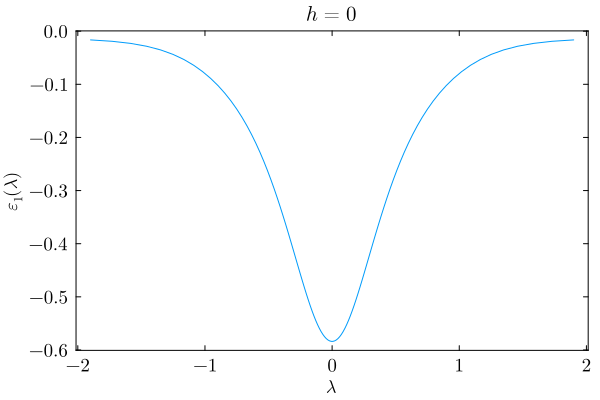

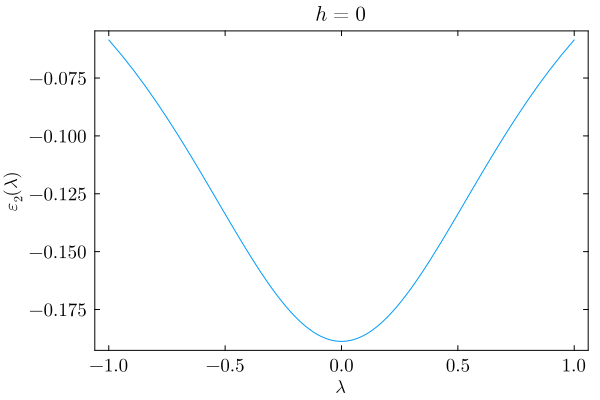

In [ ]:
D=0.1
B1=1.9; B2=1.0

e, u=dressed_energy(B1, abs.(B2), M, 0, D)
p1=plot(f(u, abs.(B1)), e[1:M], xlabel=L"\lambda", ylabel=L"\epsilon_1(\lambda)", title=L"h=%$(h_)")
p2=plot(f(u, abs.(B2)), e[M+1:end], xlabel=L"\lambda", ylabel=L"\epsilon_2(\lambda)", title=L"h=%$(h_)")
display(p1)
display(p2) 


In [1158]:
Ds = 0:0.1:2*sqrt(2)
h_=0
M=100
B1s=[]; B2s=[]
for D in Ds
    function residual!(F, x)
        B1, B2 = x
        F[1], F[2] = dressed_boundary(B1, B2, M, h_, D)
    end

    x0 = [5., 0.1]
    sol = nlsolve(residual!, x0)
    B1_temp, B2_temp = sol.zero
    push!(B1s, abs.(B1_temp))
    push!(B2s, abs.(B2_temp))
end

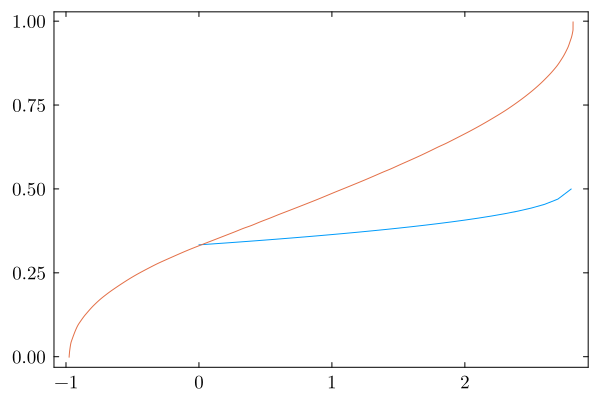

In [1159]:
using CubicSplines

n1 = zeros(length(B1s))
n2 = zeros(length(B2s))
for j in eachindex(B1s)
    n1[j], n2[j] = density(abs.(B1s[j]), abs.(B2s[j]))
end

## Bethe ansatz
df = CSV.read("../DMRG/sim/P0_Bethe.csv", DataFrame)
D=sort(df[:,1]/sqrt(2))
n0=sort(df[:,2])
@show D[end]

# spline interpolation
n_spline=10000
n0_spline = zeros(n_spline)
D_spline = LinRange(D[1], D[end], n_spline)

spline = CubicSpline(D, n0)
n0_spline = spline(D_spline)

n0 = [n1[j]/(2*pi)-n2[j]/(2*pi) for j in 1:length(B1s)]
plot(Ds, n0)
plot!(D_spline, n0_spline)

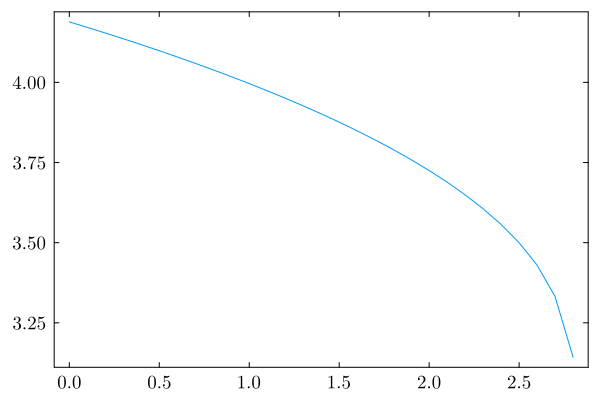

In [ ]:
n = [n1[j]/(2*pi) for j in 1:length(B1s)]
plot(Ds, n1)


In [1135]:
@show diff(Ds)


282-element Vector{Float64}:
 0.01
 0.01
 0.009999999999999998
 0.010000000000000002
 0.010000000000000002
 0.009999999999999995
 0.010000000000000009
 0.009999999999999995
 0.009999999999999995
 0.010000000000000009
 ⋮
 0.010000000000000231
 0.009999999999999787
 0.010000000000000231
 0.009999999999999787
 0.010000000000000231
 0.009999999999999787
 0.010000000000000231
 0.009999999999999787
 0.009999999999999787